In [1]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 116.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 51.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-05 22:32:44--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.60.144, 52.216.49.104, 54.231.228.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.60.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.94MB/s    in 2.2s    

2023-11-05 22:32:47 (5.94 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Examining the Jena weather dataset, consisting of 420,451 rows and encompassing 15 features, is pivotal for analysis and modeling.**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing involves converting comma-separated values to floating-point numbers. Subsequently, storing selected values in temperature and raw_data arrays facilitates further processing or analysis.**

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]


**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

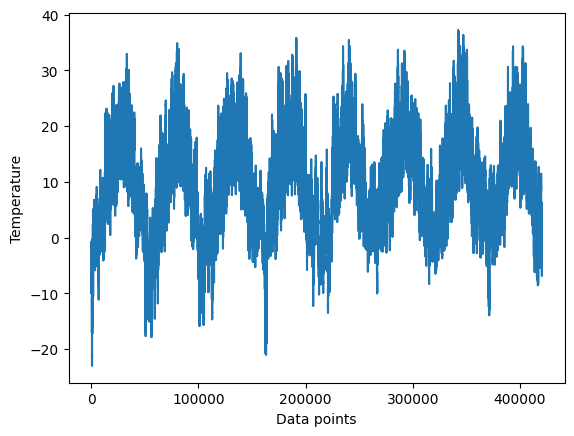

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Generating a plot for the initial 10 days of the temperature timeseries, considering the daily 144 data points, resulting in 1440 data points.**

Text(0, 0.5, 'Temperature')

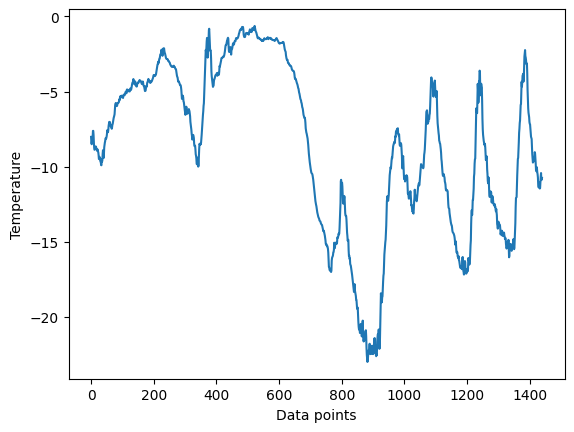

In [7]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Calculating the sample distribution for data splits: allocating 50% for training and 25% for validation to optimize dataset segmentation.**

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Preparing the data**

**Normalizing the numerical data doesn't require vectorization. However, due to variable scale differences (e.g., temperature -20 to +30, pressure in millibars), standardizing all variables is recommended.**

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Creating datasets for training, validation, and testing is necessary due to highly redundant samples. Dynamically generating samples is more efficient than allocating memory for each one explicitly.**

In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**Common-sense, non-machine-learning baseline**

**Calculating the Mean Absolute Error (MAE) for the common-sense baseline is crucial. The "evaluate_naive_method" function establishes a simple forecasting approach, predicting the next value based on the last in the input sequence.**

In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


The common-sense baseline involves predicting the future temperature to be the same as the current temperature, resulting in a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. This simplistic approach assumes a constant temperature, leading to an average deviation of approximately two and a half degrees. It serves as a fundamental reference for evaluating the performance of more sophisticated forecasting models in the analysis of temperature trends over time.

 **Basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [16]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 19s 17ms/step - loss: 17.0885 - mae: 3.1811 - val_loss: 12.4871 - val_mae: 2.7783
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 11.4472 - mae: 2.6768 - val_loss: 14.2101 - val_mae: 3.0233
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 10.5871 - mae: 2.5713 - val_loss: 11.2604 - val_mae: 2.6446
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 10.0423 - mae: 2.5009 - val_loss: 10.7705 - val_mae: 2.5978
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 9.6061 - mae: 2.4434 - val_loss: 10.7968 - val_mae: 2.6042
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 9.2252 - mae: 2.3952 - val_loss: 10.6914 - val_mae: 2.5803
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 8.8099 - mae: 2.3393 - val_loss: 11.3877 - val_mae: 2.6636
Epoch 8/10
819/819 [==============================]

In [18]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 5s 11ms/step - loss: 11.2389 - mae: 2.6364
Test MAE: 2.64


**Plotting**

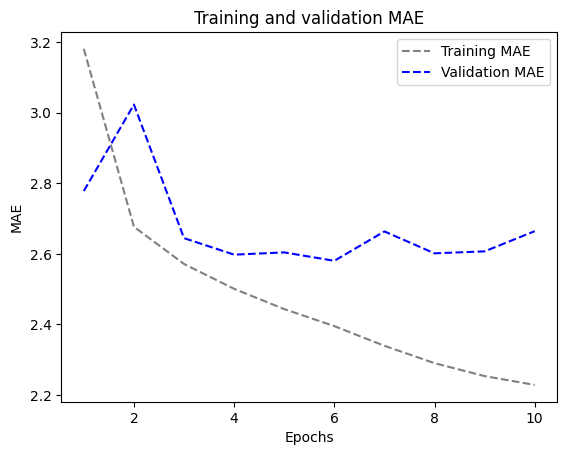

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


 **Trying a 1D convolutional model**

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 20s 18ms/step - loss: 21.7661 - mae: 3.6698 - val_loss: 19.0804 - val_mae: 3.4393
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 15.4408 - mae: 3.1212 - val_loss: 13.8778 - val_mae: 2.9417
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 14.1491 - mae: 2.9810 - val_loss: 14.0608 - val_mae: 2.9501
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 13.3094 - mae: 2.8861 - val_loss: 15.4289 - val_mae: 3.0791
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 12.6866 - mae: 2.8134 - val_loss: 13.0811 - val_mae: 2.8545
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 12.2159 - mae: 2.7605 - val_loss: 13.3974 - val_mae: 2.8838
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 11.8278 - mae: 2.7154 - val_loss: 12.8634 - val_mae: 2.8138
Epoch 8/10
819/819 [============================

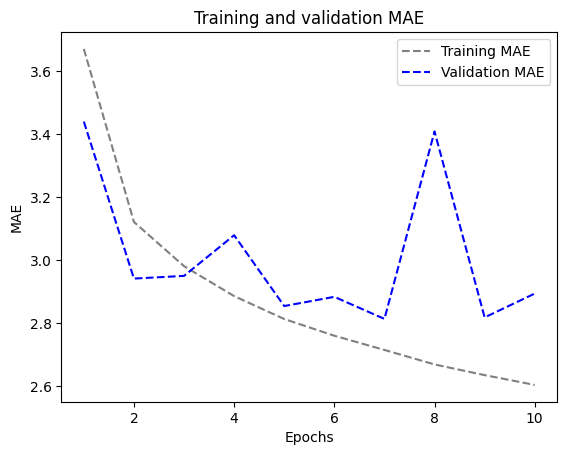

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Simple RNN**


**1. RNN layer that can process sequences of any length**

In [22]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 58ms/step - loss: 139.1521 - mae: 9.7122 - val_loss: 143.9337 - val_mae: 9.8912
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 136.4892 - mae: 9.5667 - val_loss: 143.7700 - val_mae: 9.8778
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 136.3158 - mae: 9.5506 - val_loss: 143.6794 - val_mae: 9.8648
Epoch 4/10
819/819 [==============================] - 46s 57ms/step - loss: 136.2515 - mae: 9.5444 - val_loss: 143.5999 - val_mae: 9.8563
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 136.1915 - mae: 9.5405 - val_loss: 143.6646 - val_mae: 9.8655
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 136.1673 - mae: 9.5398 - val_loss: 143.5811 - val_mae: 9.8524
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 136.1546 - mae: 9.5379 - val_loss: 143.6736 - val_mae: 9.8691
Epoch 8/10
819/819 [==============

**2.Simple RNN - Stacking RNN layers**

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 192s 231ms/step - loss: 136.9699 - mae: 9.5703 - val_loss: 143.4518 - val_mae: 9.8416
Epoch 2/10
819/819 [==============================] - 189s 230ms/step - loss: 136.0056 - mae: 9.5184 - val_loss: 143.4334 - val_mae: 9.8392
Epoch 3/10
819/819 [==============================] - 189s 230ms/step - loss: 135.9659 - mae: 9.5131 - val_loss: 143.4281 - val_mae: 9.8379
Epoch 4/10
819/819 [==============================] - 187s 229ms/step - loss: 135.9489 - mae: 9.5107 - val_loss: 143.4491 - val_mae: 9.8441
Epoch 5/10
819/819 [==============================] - 188s 230ms/step - loss: 135.9208 - mae: 9.5076 - val_loss: 143.4859 - val_mae: 9.8481
Epoch 6/10
819/819 [==============================] - 187s 228ms/step - loss: 135.9110 - mae: 9.5061 - val_loss: 143.4090 - val_mae: 9.8354
Epoch 7/10
819/819 [==============================] - 187s 228ms/step - loss: 135.8953 - mae: 9.5037 - val_loss: 143.4699 - val_mae: 9.8466
Epoch 8/10
819/819 [

**Simple GRU (Gated Recurrent Unit)**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 18ms/step - loss: 43.8707 - mae: 4.8058 - val_loss: 13.0201 - val_mae: 2.7067
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 10.7141 - mae: 2.5436 - val_loss: 9.4540 - val_mae: 2.3719
Epoch 3/10
819/819 [==============================] - 14s 18ms/step - loss: 9.5514 - mae: 2.4089 - val_loss: 9.5307 - val_mae: 2.3793
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 9.1959 - mae: 2.3608 - val_loss: 9.8464 - val_mae: 2.4016
Epoch 5/10
819/819 [==============================] - 14s 18ms/step - loss: 8.9351 - mae: 2.3288 - val_loss: 9.3717 - val_mae: 2.3698
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 8.7370 - mae: 2.3058 - val_loss: 9.5313 - val_mae: 2.3893
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 8.5486 - mae: 2.2840 - val_loss: 9.4733 - val_mae: 2.3868
Epoch 8/10
819/819 [==============================] - 15s 1

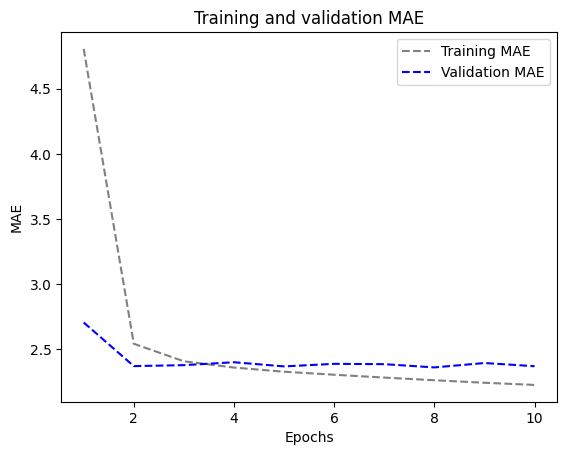

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM(Long Short-Term Memory )**

**1.LSTM-Simple**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 18ms/step - loss: 42.9901 - mae: 4.7641 - val_loss: 12.9209 - val_mae: 2.7243
Epoch 2/10
819/819 [==============================] - 14s 18ms/step - loss: 10.8198 - mae: 2.5535 - val_loss: 9.7777 - val_mae: 2.4293
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 9.5357 - mae: 2.4092 - val_loss: 9.5973 - val_mae: 2.4148
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 8.9868 - mae: 2.3428 - val_loss: 9.4466 - val_mae: 2.4030
Epoch 5/10
819/819 [==============================] - 14s 18ms/step - loss: 8.5642 - mae: 2.2884 - val_loss: 9.9295 - val_mae: 2.4666
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 8.2189 - mae: 2.2434 - val_loss: 9.8094 - val_mae: 2.4435
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 7.9769 - mae: 2.2078 - val_loss: 9.6315 - val_mae: 2.4273
Epoch 8/10
819/819 [==============================] - 14s 1

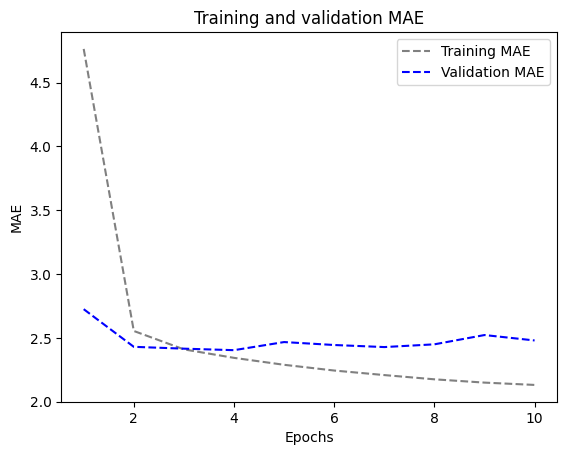

In [27]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**2.LSTM - dropout Regularization**

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 236s 285ms/step - loss: 47.6336 - mae: 5.1641 - val_loss: 13.7181 - val_mae: 2.8052
Epoch 2/10
819/819 [==============================] - 232s 283ms/step - loss: 20.0633 - mae: 3.4428 - val_loss: 10.1768 - val_mae: 2.4857
Epoch 3/10
819/819 [==============================] - 232s 284ms/step - loss: 18.3048 - mae: 3.2927 - val_loss: 9.8063 - val_mae: 2.4532
Epoch 4/10
819/819 [==============================] - 232s 284ms/step - loss: 17.4695 - mae: 3.2212 - val_loss: 9.7901 - val_mae: 2.4508
Epoch 5/10
819/819 [==============================] - 231s 282ms/step - loss: 16.8387 - mae: 3.1631 - val_loss: 9.7261 - val_mae: 2.4457
Epoch 6/10
819/819 [==============================] - 232s 283ms/step - loss: 16.5560 - mae: 3.1339 - val_loss: 9.4701 - val_mae: 2.4166
Epoch 7/10
819/819 [==============================] - 232s 283ms/step - loss: 16.0925 - mae: 3.0891 - val_loss: 9.7500 - val_mae: 2.4435
Epoch 8/10
819/819 [===================

405/405 [==============================] - 15s 36ms/step - loss: 10.7840 - mae: 2.5814
Test MAE: 2.58


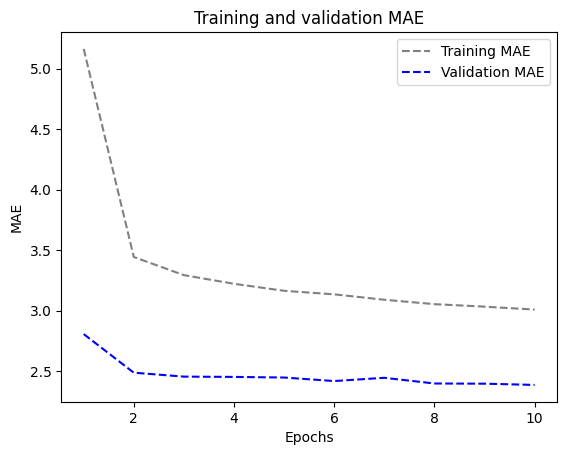

In [29]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**3.LSTM - Stacked setup with 16 units**

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 19ms/step - loss: 42.4532 - mae: 4.7293 - val_loss: 13.3965 - val_mae: 2.7563
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 10.4628 - mae: 2.5122 - val_loss: 9.7324 - val_mae: 2.4182
Epoch 3/10
819/819 [==============================] - 15s 19ms/step - loss: 8.8157 - mae: 2.3252 - val_loss: 9.9959 - val_mae: 2.4694
Epoch 4/10
819/819 [==============================] - 16s 19ms/step - loss: 8.1632 - mae: 2.2395 - val_loss: 9.6711 - val_mae: 2.4253
Epoch 5/10
819/819 [==============================] - 15s 19ms/step - loss: 7.7462 - mae: 2.1811 - val_loss: 9.5698 - val_mae: 2.4128
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 7.3453 - mae: 2.1229 - val_loss: 10.4697 - val_mae: 2.5271
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 7.0181 - mae: 2.0718 - val_loss: 9.9976 - val_mae: 2.4729
Epoch 8/10
819/819 [==============================] - 15s 

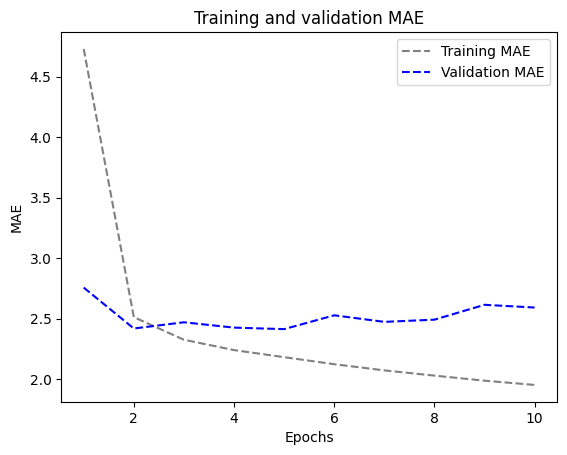

In [31]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**4.LSTM - Stacked setup with 32 units**

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 19ms/step - loss: 20.1018 - mae: 3.2298 - val_loss: 9.8706 - val_mae: 2.4544
Epoch 2/10
819/819 [==============================] - 15s 19ms/step - loss: 7.9299 - mae: 2.1934 - val_loss: 11.2178 - val_mae: 2.6166
Epoch 3/10
819/819 [==============================] - 15s 19ms/step - loss: 6.5308 - mae: 1.9786 - val_loss: 12.8060 - val_mae: 2.8183
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 5.6381 - mae: 1.8241 - val_loss: 11.7431 - val_mae: 2.7030
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 4.9563 - mae: 1.7035 - val_loss: 12.8641 - val_mae: 2.8403
Epoch 6/10
819/819 [==============================] - 15s 19ms/step - loss: 4.4502 - mae: 1.6100 - val_loss: 13.5582 - val_mae: 2.9172
Epoch 7/10
819/819 [==============================] - 15s 19ms/step - loss: 4.0480 - mae: 1.5301 - val_loss: 13.3116 - val_mae: 2.9111
Epoch 8/10
819/819 [==============================] - 1

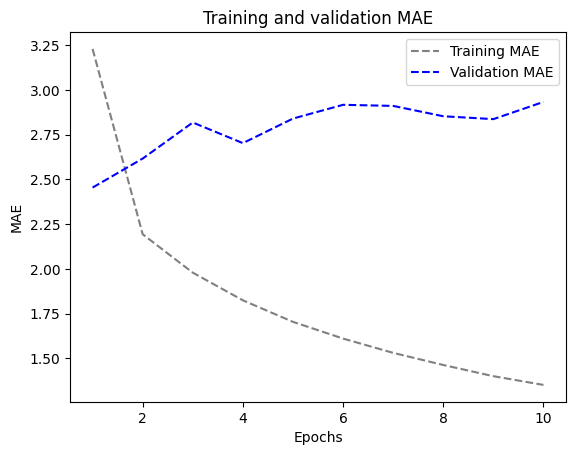

In [33]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**4.LSTM - Stacked setup with 8 units**

In [34]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 20s 20ms/step - loss: 62.8213 - mae: 6.0500 - val_loss: 30.5755 - val_mae: 4.1006
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 18.9777 - mae: 3.2413 - val_loss: 12.2278 - val_mae: 2.6470
Epoch 3/10
819/819 [==============================] - 16s 19ms/step - loss: 10.7944 - mae: 2.5475 - val_loss: 10.1438 - val_mae: 2.4613
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 9.8126 - mae: 2.4402 - val_loss: 10.2785 - val_mae: 2.4845
Epoch 5/10
819/819 [==============================] - 16s 20ms/step - loss: 9.4836 - mae: 2.3999 - val_loss: 10.1807 - val_mae: 2.4834
Epoch 6/10
819/819 [==============================] - 15s 19ms/step - loss: 9.2424 - mae: 2.3708 - val_loss: 10.2521 - val_mae: 2.4942
Epoch 7/10
819/819 [==============================] - 15s 19ms/step - loss: 9.1007 - mae: 2.3542 - val_loss: 10.0976 - val_mae: 2.4799
Epoch 8/10
819/819 [==============================] 

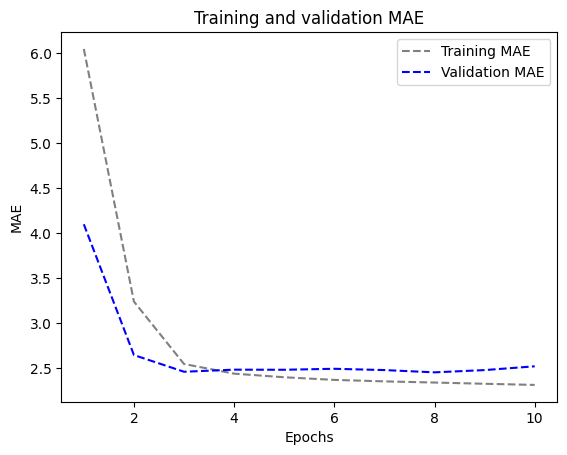

In [35]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**5.LSTM - dropout-regularized, stacked model**

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 493s 596ms/step - loss: 70.2999 - mae: 6.4082 - val_loss: 34.3219 - val_mae: 4.2726
Epoch 2/10
819/819 [==============================] - 488s 595ms/step - loss: 31.1490 - mae: 4.1579 - val_loss: 13.9910 - val_mae: 2.8041
Epoch 3/10
819/819 [==============================] - 488s 596ms/step - loss: 24.1271 - mae: 3.7140 - val_loss: 11.1847 - val_mae: 2.5631
Epoch 4/10
819/819 [==============================] - 488s 595ms/step - loss: 22.3104 - mae: 3.5778 - val_loss: 10.8442 - val_mae: 2.5451
Epoch 5/10
819/819 [==============================] - 489s 597ms/step - loss: 20.9503 - mae: 3.4761 - val_loss: 10.6385 - val_mae: 2.5324
Epoch 6/10
819/819 [==============================] - 489s 597ms/step - loss: 20.0633 - mae: 3.4044 - val_loss: 10.6457 - val_mae: 2.5360
Epoch 7/10
819/819 [==============================] - 487s 595ms/step - loss: 19.1433 - mae: 3.3298 - val_loss: 10.2726 - val_mae: 2.4963
Epoch 8/10
819/819 [==============

405/405 [==============================] - 27s 66ms/step - loss: 11.3159 - mae: 2.6422
Test MAE: 2.64


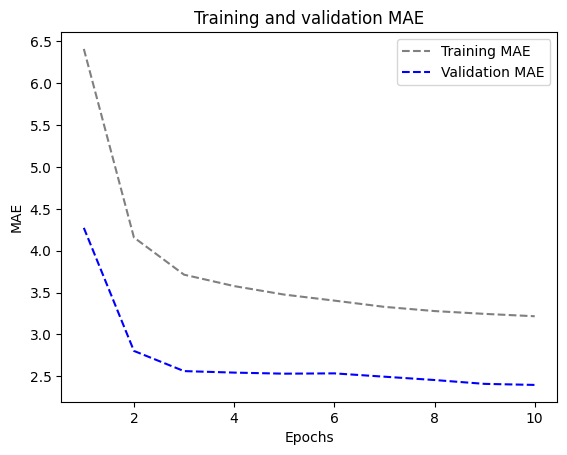

In [37]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Bidirectional LSTM**

In [38]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 19ms/step - loss: 28.7436 - mae: 3.8531 - val_loss: 10.8958 - val_mae: 2.5568
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 9.7689 - mae: 2.4403 - val_loss: 9.8193 - val_mae: 2.4327
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 8.9758 - mae: 2.3292 - val_loss: 9.8813 - val_mae: 2.4308
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 8.5342 - mae: 2.2694 - val_loss: 9.7872 - val_mae: 2.4123
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 8.2539 - mae: 2.2394 - val_loss: 9.7831 - val_mae: 2.4175
Epoch 6/10
819/819 [==============================] - 16s 19ms/step - loss: 7.9634 - mae: 2.2011 - val_loss: 9.9689 - val_mae: 2.4417
Epoch 7/10
819/819 [==============================] - 16s 19ms/step - loss: 7.6989 - mae: 2.1677 - val_loss: 10.2687 - val_mae: 2.4670
Epoch 8/10
819/819 [==============================] - 15s 1

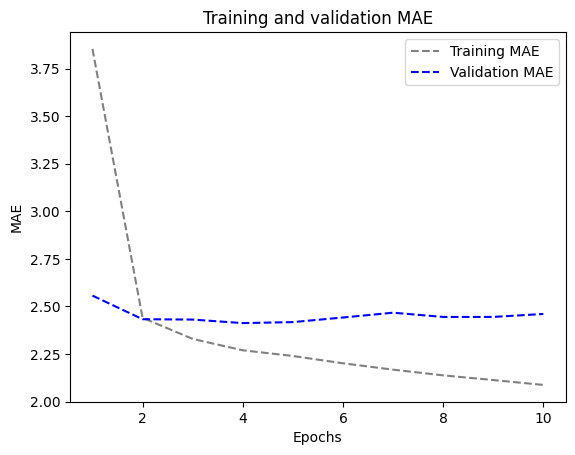

In [39]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**1D Convnets and LSTM togther**

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 18ms/step - loss: 51.5592 - mae: 5.3756 - val_loss: 26.1900 - val_mae: 3.9822
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 17.8970 - mae: 3.2627 - val_loss: 22.7788 - val_mae: 3.8276
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 14.6218 - mae: 2.9636 - val_loss: 22.2839 - val_mae: 3.7822
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 12.9825 - mae: 2.7876 - val_loss: 22.2015 - val_mae: 3.7118
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 11.8048 - mae: 2.6512 - val_loss: 21.3349 - val_mae: 3.7300
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 10.9292 - mae: 2.5447 - val_loss: 22.8502 - val_mae: 3.7691
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 10.2310 - mae: 2.4616 - val_loss: 24.5661 - val_mae: 3.8940
Epoch 8/10
819/819 [============================

We built 13 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - Stacking RNN layers

Model 6: A Simple GRU (Gated Recurrent Unit)

Model 7: LSTM-Simple

Model 8: LSTM - dropout Regularization

Model 9: LSTM Stacked setup with 16 units

Model 10: LSTM Stacked setup with 32 units

Model 11: LSTM Stacked setup with 8 units

Model 12: LSTM - dropout-regularized, stacked up with 8unit

Model 13: Bidirectional LSTM

Model 14: 1D Convnets and LSTM togther

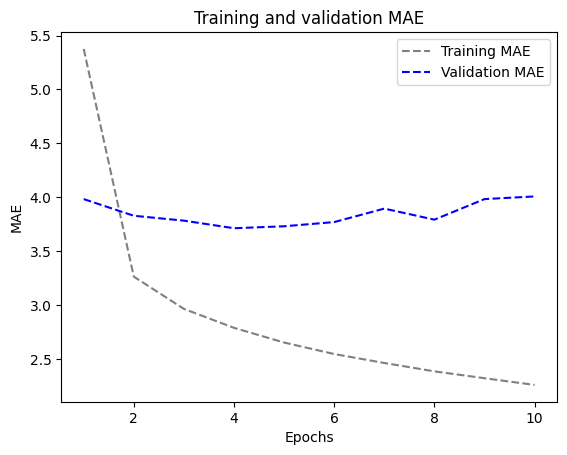

In [41]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

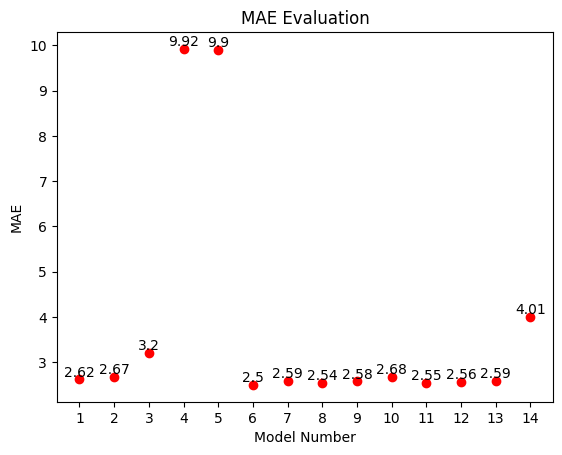

In [42]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

In conclusion, we constructed a total of 14 models for our analysis. The initial model served as a baseline, employing common sense, and yielded a Mean Absolute Error (MAE) of 2.62. Subsequently, a basic machine learning model using a dense layer was created, resulting in a slightly higher MAE of 2.64. The performance of the dense layer was suboptimal, primarily because the connected approach flattened the time series, erasing temporal information from the input data.

We also experimented with a convolutional model, but it produced unsatisfactory results as it treated all data segments uniformly, disrupting the inherent order of information. Recognizing the specific requirements of time series data, we turned to Recurrent Neural Networks (RNNs). The distinguishing feature of RNNs is their capacity to incorporate information from previous steps in decision-making, facilitating the capture of dependencies and patterns in sequential data.

While the simple RNN is theoretically capable of retaining information for all preceding time periods, it struggled in practice, largely due to the vanishing gradient problem. This issue makes learning difficult, especially in deep networks. To address this limitation, LSTM and GRU RNNs were introduced in Keras. Our experimentation revealed that the simple GRU outperformed all other models, demonstrating its effectiveness in capturing long-range dependencies in sequential data while maintaining computational efficiency compared to LSTMs.

LSTMs stand out as a prominent architecture for handling time series data. In our exploration, we implemented six distinct LSTM models, varying the units in stacking recurrent layers to 8, 16, and 32. Notably, the model with 8 units yielded the most favorable outcome among the three unit configurations. Additionally, we incorporated recurrent dropout to counteract overfitting and experimented with Bidirectional data, presenting the recurrent network with information in different orientations. This approach enhanced accuracy and addressed potential forgetting issues. In our final endeavor, we synthesized a hybrid model amalgamating a 1D convolutional model with a Recurrent Neural Network (RNN). However, the outcome was suboptimal, with a relatively high Mean Absolute Error (MAE) of 3.88. This lackluster performance is likely attributed to the inherent limitation

All of these LSTM models exhibited MAE values in close proximity to each other, and notably, all achieved lower MAE values compared to the common sense model. This observation is further validated by the MAE evaluation graph, reaffirming the effectiveness of LSTM architectures in our time series data analysis. s of convolutional approaches, specifically their tendency to disrupt the inherent order of information within sequential data. The convolutional model, despite its strengths in certain contexts, appeared to clash with the sequential nature of the data, resulting in diminished predictive accuracy. This underlines the importance of choosing models that align seamlessly with the inherent characteristics of the dataset for optimal results.

Recommendation:-From my observations, it's evident that simple RNNs grapple with the vanishing gradient problem, limiting their effectiveness in capturing long-term dependencies. Opting for more advanced RNN architectures like LSTM and GRU is advisable, given their design to overcome these challenges. While LSTM is a popular choice for time series data due to its capability to capture long-term dependencies, experiments suggest that GRU might offer a more efficient alternative. I recommend optimizing the GRU model by fine-tuning hyperparameters, including the number of units in stacked recurrent layers, recurrent dropout rate, and the utilization of bidirectional data.

In light of the obtained results, the combined 1D convolution and RNN approach proved suboptimal. The convolutional method's tendency to disrupt the order of information in time series data suggests a preference for architectures tailored explicitly for sequential data, such as standalone RNNs.